In [1]:
import torch
import torchvision
from torch.utils.data import Subset
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from os import listdir, path
from  shutil import rmtree
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
train_on_gpu = torch.cuda.is_available()

In [3]:
BASE_DIR = "./dogs_dataset"

BULDOGUE_DIR = path.join(BASE_DIR, 'buldogue_frances')
DALMATA_DIR = path.join(BASE_DIR, 'dalmata')
GOLDEN_DIR = path.join(BASE_DIR, 'golden_retriever')
LABRADOR_DIR = path.join(BASE_DIR, 'labrador')
PINSCHER_DIR = path.join(BASE_DIR, 'pinscher')
PUG_DIR = path.join(BASE_DIR, 'pug')
YORKSHIRE_DIR = path.join(BASE_DIR, 'yorkshire')

In [4]:
images_per_breed = {
    "buldogue_frances": len(listdir(BULDOGUE_DIR)),
    "dalmata": len(listdir(DALMATA_DIR)),
    "golden_retriever": len(listdir(GOLDEN_DIR)),
    "labrador": len(listdir(LABRADOR_DIR)),
    "pinscher": len(listdir(PINSCHER_DIR)),
    "pug": len(listdir(PUG_DIR)),
    "yorkshire": len(listdir(YORKSHIRE_DIR))
}
classes = list(images_per_breed.keys())

for key,value in images_per_breed.items():
    print(f"Class {key} has {value} images.")
    
print(f"This dataset has a total of {sum(images_per_breed.values())} images.")

Class buldogue_frances has 306 images.
Class dalmata has 270 images.
Class golden_retriever has 397 images.
Class labrador has 392 images.
Class pinscher has 232 images.
Class pug has 310 images.
Class yorkshire has 339 images.
This dataset has a total of 2246 images.


In [5]:
def checkImage(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False
    
def train_test_dataset(dataset, test_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train = Subset(dataset, train_idx)
    val = Subset(dataset, val_idx)
    return train, val

def plot_images(images, labels, classes, nmb_images=None):
    # plot the images in the batch, along with the corresponding labels
    nmb_images = nmb_images if nmb_images else len(images)
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(nmb_images):
        ax = fig.add_subplot(2, nmb_images//2, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(
            list(classes.keys())[list(classes.values()).index(labels[idx])])

In [6]:
jupyter_chckpoint = path.join(BASE_DIR, '.ipynb_checkpoints')
if path.exists(jupyter_chckpoint) and path.isdir(jupyter_chckpoint):
    rmtree(jupyter_chckpoint)

    
img_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
])

dataset = datasets.ImageFolder(root = BASE_DIR, transform = img_transforms, is_valid_file = checkImage)

In [7]:
dataset.class_to_idx

{'buldogue_frances': 0,
 'dalmata': 1,
 'golden_retriever': 2,
 'labrador': 3,
 'pinscher': 4,
 'pug': 5,
 'yorkshire': 6}

In [8]:
train_dataset, test_dataset = train_test_dataset(dataset, test_split=0.15)

# define dataloader parameters
batch_size = 16
num_workers= 6

#Full dataset dataloader
dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

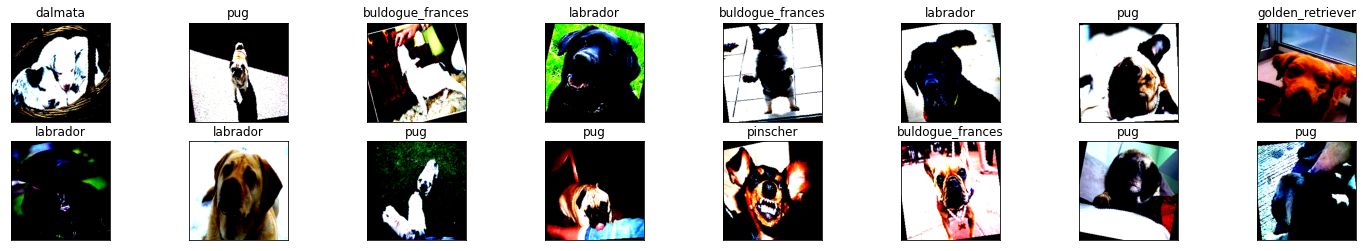

In [9]:
images, labels = next(iter(dataset_loader))
images = images.numpy()

plot_images(images, labels, classes = dataset.class_to_idx , nmb_images = batch_size)

In [10]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)

model = ResNet50(num_classes=7)

In [11]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.001
# optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)
# optimizer = optim.SGD(model.fc.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [12]:
def train_model(_model, _optimizer, n_epochs):  
  # number of epochs to train the model
    for epoch in range(1, n_epochs+1):
        # keep track of training and validation loss
        train_loss = 0.0 
        ###################
        # train the model #
        ###################
        # model by default is set to train
        for batch_i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            _optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = _model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            _optimizer.step()
            # update training loss 
            train_loss += loss.item()
          
            if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
                print('Epoch %d, Batch %d loss: %.16f' %
                    (epoch, batch_i + 1, train_loss / 20))
                train_loss = 0.0

In [13]:
if train_on_gpu:
    model.cuda()
    
train_model(model,optimizer,n_epochs=50)

Epoch 1, Batch 20 loss: 1.9653479993343352
Epoch 1, Batch 40 loss: 1.8845521330833435
Epoch 1, Batch 60 loss: 1.9068572580814362
Epoch 1, Batch 80 loss: 1.8877663195133210
Epoch 1, Batch 100 loss: 1.8932935714721679
Epoch 1, Batch 120 loss: 1.8170121669769288
Epoch 2, Batch 20 loss: 1.8846249163150788
Epoch 2, Batch 40 loss: 1.8511956155300140
Epoch 2, Batch 60 loss: 1.8568779289722444
Epoch 2, Batch 80 loss: 1.8547380030155183
Epoch 2, Batch 100 loss: 1.8285583019256593
Epoch 2, Batch 120 loss: 1.7783032059669495
Epoch 3, Batch 20 loss: 1.8337481975555421
Epoch 3, Batch 40 loss: 1.8327246963977815
Epoch 3, Batch 60 loss: 1.8101242065429688
Epoch 3, Batch 80 loss: 1.8358942925930024
Epoch 3, Batch 100 loss: 1.7861855566501617
Epoch 3, Batch 120 loss: 1.7871916770935059
Epoch 4, Batch 20 loss: 1.7971497118473052
Epoch 4, Batch 40 loss: 1.8578291475772857
Epoch 4, Batch 60 loss: 1.8085746049880982
Epoch 4, Batch 80 loss: 1.8101873695850372
Epoch 4, Batch 100 loss: 1.7981963336467743
Epoc

In [14]:
torch.save(model, "models/resnet50-scratch.pth")

In [15]:
def evaluate_model(_model):  
    # track test loss 
    # over 5 flower classes
    test_loss = 0.0
    class_correct = list(0. for i in range(_model.fc.out_features))
    class_total = list(0. for i in range(_model.fc.out_features))

    _model.eval() # eval mode

    # iterate over test data
    for data, target in test_loader:
        # # move tensors to GPU if CUDA is available
        # if train_on_gpu:
        #     data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = _model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update  test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate avg test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(_model.fc.out_features):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                list(dataset.class_to_idx.keys())[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [16]:
# model = torch.load("models/resnet50-scratch.pth")

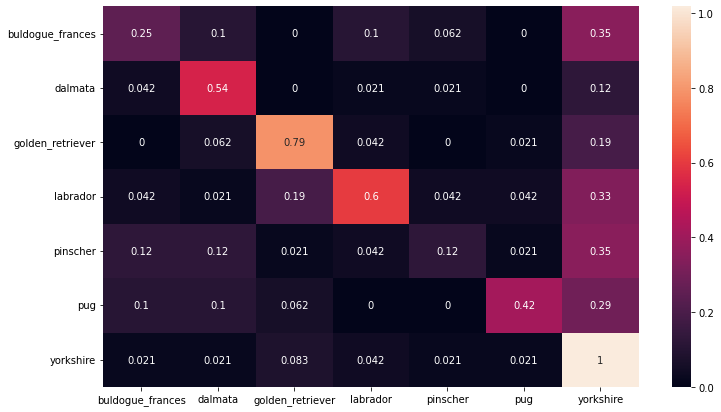

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

model.eval()
# iterate over test data
for inputs, labels in test_loader:
        if torch.cuda.is_available():
            model.cuda()
            inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('buldogue_frances', 'dalmata', 'golden_retriever', 'labrador', 'pinscher',
        'pug', 'yorkshire')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*7, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('resnet50-scratch.png')